In [1]:
import pycutestmgr as cute
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csc_matrix
from ipsolver import eqp_kktfact, projections, projected_cg
from numpy.testing import (TestCase, assert_array_almost_equal,
                           assert_array_equal, assert_array_less,
                           assert_raises, assert_equal, assert_,
                           run_module_suite, assert_allclose, assert_warns,
                           dec)
cute.clearCache('HS71')

In [2]:
list_names = ("CVXQP1_S",
              "CVXQP2_S",
              "CVXQP3_S", 
              "CVXQP1_M",
              "CVXQP2_M",
              "CVXQP3_M",
              "CVXQP1_L",
              "CVXQP2_L",
              "CVXQP3_L",
              "CONT-050",
              "CONT-100",
              "DPKLO1",
              "MOSARQP1",
              "DUAL1",
              "DUAL2",
              "DUAL3",
              "DUAL4",
              "PRIMAL1",
              "PRIMAL2",
              "LASER")
n = len(list_names)

kkt_time = np.zeros(n)
factorization_time_ne = np.zeros(n)
cg_time_ne = np.zeros(n)
factorization_time_as = np.zeros(n)
cg_time_as = np.zeros(n)
constr_ne = np.zeros(n)
constr_as = np.zeros(n)
constr_kkt = np.zeros(n)
opt_ne = np.zeros(n)
opt_as = np.zeros(n)
opt_kkt = np.zeros(n)
niter_ne = np.zeros(n)
niter_as = np.zeros(n)

k = 0
for name in list_names:
    print(name)
    cute.prepareProblem(name)
    problem=cute.importProblem(name)
    info = problem.getinfo()
    x0 = info["x"]
    G = problem.ihess(x0)
    f, c = problem.obj(x0, True) 
    b, A = problem.cons(x0, True)

    G = csc_matrix(G)
    A = csc_matrix(A)

    start_time = time.time()
    x, lambd = eqp_kktfact(G, c, A, -b)
    kkt_time[k] = time.time() - start_time

    start_time = time.time()
    Z, _, Y = projections(A, method='NormalEquation')
    factorization_time_ne[k] =  time.time() - start_time

    start_time = time.time()
    x_ne, info_ne = projected_cg(G, c, Z, Y, -b, tol=1e-12)
    cg_time_ne[k] = time.time() - start_time

    start_time = time.time()
    Z, _, Y = projections(A, method='AugmentedSystem')
    factorization_time_as[k] = time.time() - start_time

    start_time = time.time()
    x_as, info_as = projected_cg(G, c, Z, Y, -b, tol=1e-12)
    cg_time_as[k] = time.time() - start_time

    
    constr_kkt[k] =  np.linalg.norm(A*x-b)
    constr_ne[k] =  np.linalg.norm(A*x_ne-b)
    constr_as[k] = np.linalg.norm(A*x_as-b)

    opt_kkt[k] =  1.0/2.0*G.dot(x).dot(x)+c.dot(x) + f
    opt_as[k] =  1.0/2.0*G.dot(x_as).dot(x_as)+c.dot(x_as) + f
    opt_ne[k] = 1.0/2.0*G.dot(x_ne).dot(x_ne)+c.dot(x_ne) + f
    
    niter_as[k] = info_as['niter']
    niter_ne[k] = info_ne['niter']
    
    k += 1

CVXQP1_S
CVXQP2_S
CVXQP3_S
CVXQP1_M
CVXQP2_M
CVXQP3_M
CVXQP1_L
CVXQP2_L
CVXQP3_L
CONT-050
CONT-100
DPKLO1
MOSARQP1
DUAL1
DUAL2
DUAL3
DUAL4
PRIMAL1
PRIMAL2
LASER


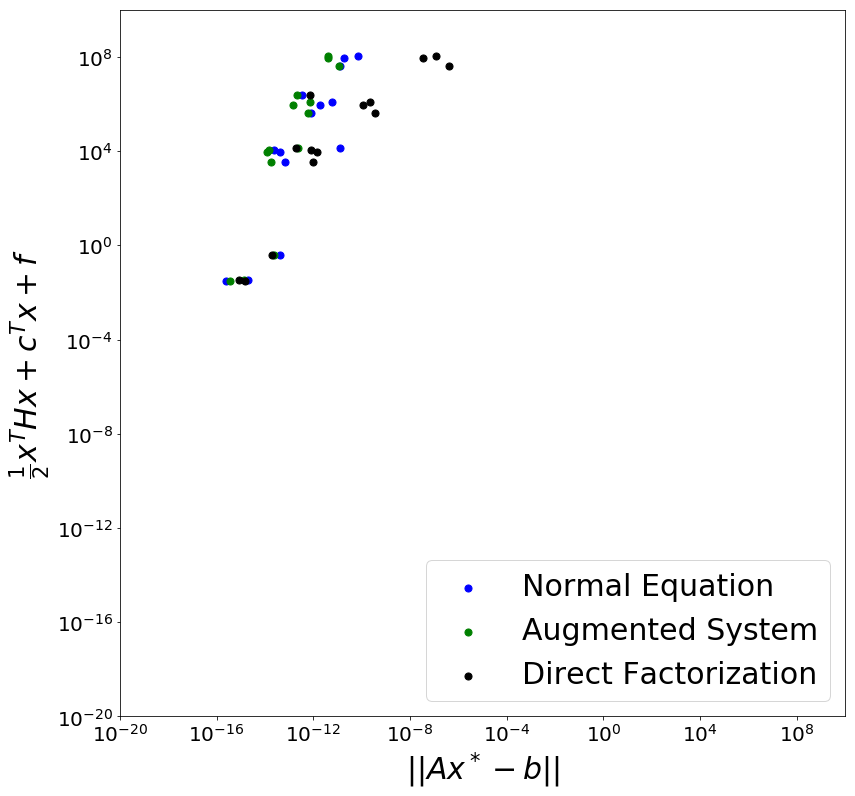

In [7]:
fig = plt.figure(figsize=(13, 13))
ax = plt.gca()
ax.scatter(constr_ne, opt_ne, s=50, color='blue', label='Normal Equation')
ax.scatter(constr_as, opt_as, s=50, color='green', label='Augmented System')
ax.scatter(constr_kkt, opt_kkt, s=50, color='black', label='Direct Factorization')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e-20, 1e10])
ax.set_ylim([1e-20, 1e10])
ax.set_xlabel(r"$\||A x^*-b\||$", fontsize=30)
ax.set_ylabel(r"$\frac{1}{2}x^T H x + c^T x + f$", fontsize=30)
ax.legend(fontsize=30, loc=4)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig("optimality_x_error_after.png")

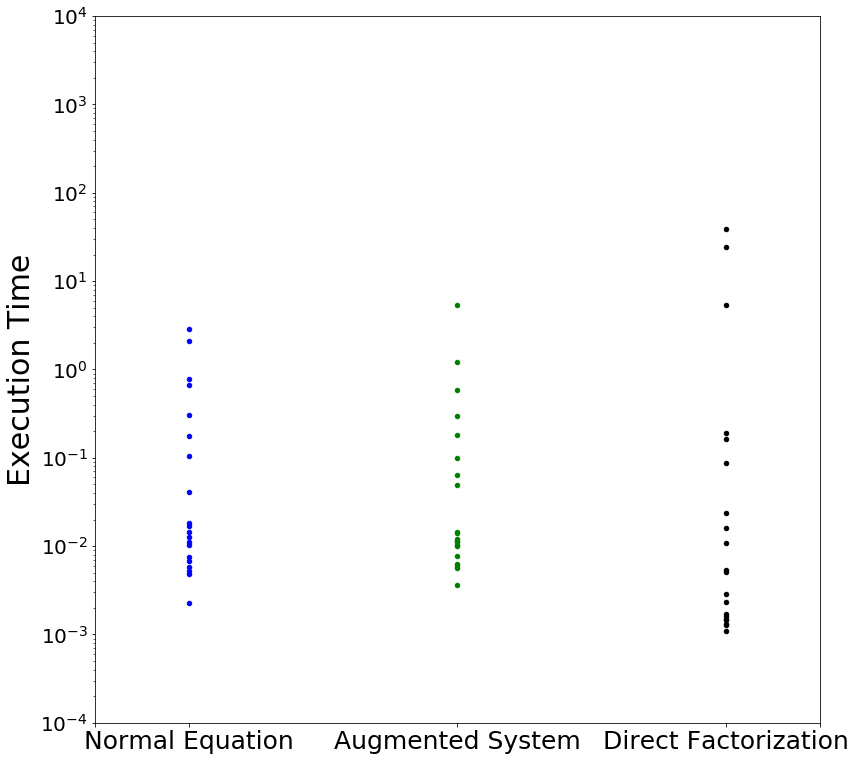

In [8]:
fig = plt.figure(figsize=(13, 13))
ax = plt.gca()
ax.scatter(np.ones(n), factorization_time_ne+cg_time_ne, s=20, color='blue', label='Normal Equation')
ax.scatter(2*np.ones(n), factorization_time_as+ cg_time_as, s=20, color='green', label='Augmented System')
ax.scatter(3*np.ones(n), kkt_time, s=20, color='black', label='Direct Factorization')
ax.set_ylabel(r"Execution Time", fontsize=30)
ax.set_yscale('log')
ax.set_ylim([1e-4, 1e4])
ax.set_xticks([0.65, 1, 2, 3, 3.35])
ax.set_xticklabels(["", 'Normal Equation', 'Augmented System', 'Direct Factorization', ""], fontsize=25)
plt.tick_params(axis='y', which='both', labelsize=20)
# plt.savefig("execution_time_after.png")

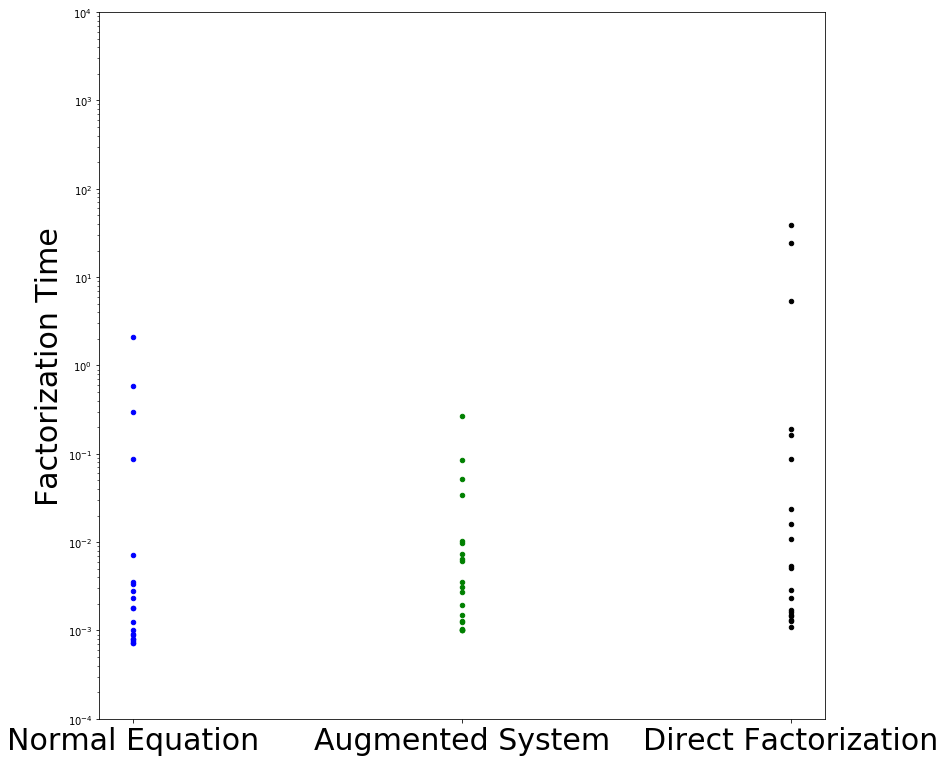

In [9]:
fig = plt.figure(figsize=(13, 13))
ax = plt.gca()
ax.scatter(np.ones(n), factorization_time_ne, s=20, color='blue', label='Normal Equation')
ax.scatter(2*np.ones(n), factorization_time_as, s=20, color='green', label='Augmented System')
ax.scatter(3*np.ones(n), kkt_time, s=20, color='black', label='Direct Factorization')
ax.set_ylabel(r"Factorization Time", fontsize=30)
ax.set_yscale('log')
ax.set_ylim([1e-4, 1e4])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Normal Equation', 'Augmented System', 'Direct Factorization'], fontsize=30)

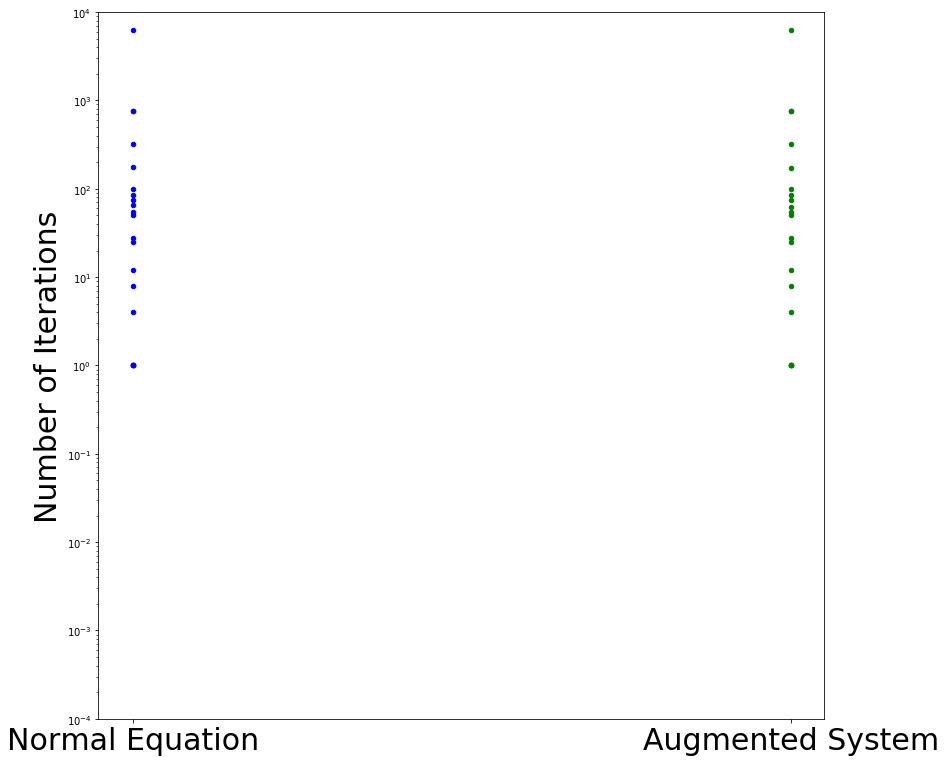

In [10]:
fig = plt.figure(figsize=(13, 13))
ax = plt.gca()
ax.scatter(np.ones(n), niter_ne, s=20, color='blue', label='Normal Equation')
ax.scatter(2*np.ones(n), niter_as, s=20, color='green', label='Augmented System')
ax.set_ylabel(r"Number of Iterations", fontsize=30)
ax.set_yscale('log')
ax.set_ylim([1e-4, 1e4])
ax.set_xticks([1, 2])
ax.set_xticklabels(['Normal Equation', 'Augmented System'], fontsize=30)